<a href="https://colab.research.google.com/github/Nikitajain121/Data-Science/blob/main/advadigital_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Set Up Environment and Install Required Packages

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision transformers accelerate scipy safetensors


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.4/727.4 kB 13.6 MB/s eta 0:00:00


In [4]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

#2. Define General Functions

##Function to Detect Objects and Return Bounding Boxes


source - https://huggingface.co/google/owlvit-base-patch32

Detected lamp with confidence 0.11 at location [246.68, 288.59, 408.66, 638.79]
Detected vase with confidence 0.193 at location [920.85, 523.7, 1012.91, 624.6]
Detected furniture with confidence 0.175 at location [400.87, 469.64, 865.96, 648.94]


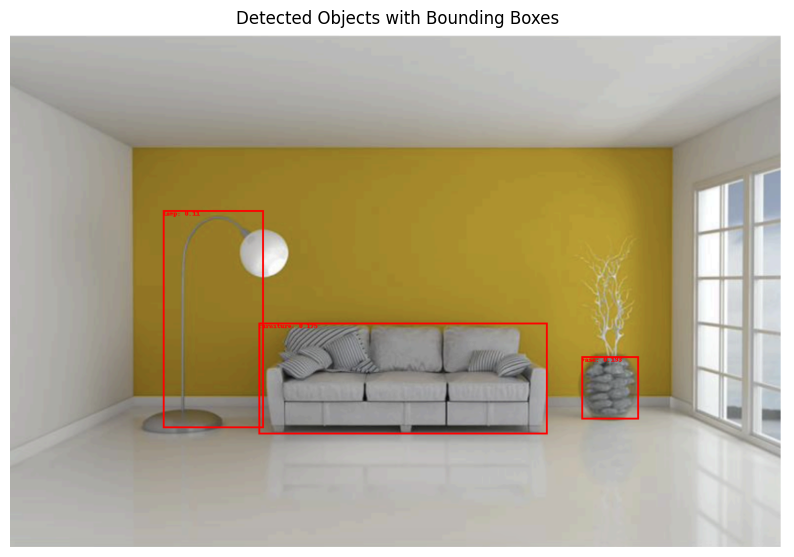

In [27]:
def detect_objects(image_path, labels, model_name="google/owlvit-base-patch32"):
    # Load processor and model
    processor = OwlViTProcessor.from_pretrained(model_name)
    model = OwlViTForObjectDetection.from_pretrained(model_name)

    # Load image and convert to RGB
    image = Image.open(image_path).convert("RGB")

    # Prepare inputs for the model
    inputs = processor(text=[labels], images=image, return_tensors="pt")
    outputs = model(**inputs)

    # Process outputs and get bounding boxes
    target_sizes = torch.Tensor([image.size[::-1]])  # Convert to height, width
    results = processor.post_process_object_detection(outputs=outputs, threshold=0.1, target_sizes=target_sizes)

    # Initialize a drawing object to overlay bounding boxes
    draw = ImageDraw.Draw(image)

    boxes = []
    for box, score, label in zip(results[0]["boxes"], results[0]["scores"], results[0]["labels"]):
        box = [round(i, 2) for i in box.tolist()]  # Convert box coordinates to list
        print(f"Detected {labels[label]} with confidence {round(score.item(), 3)} at location {box}")

        # Append box coordinates for future use
        boxes.append(box)

        # Draw the bounding box on the image
        draw.rectangle(box, outline="red", width=3)
        draw.text((box[0], box[1]), f"{labels[label]}: {round(score.item(), 3)}", fill="red")

    # Display the image with bounding boxes using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Detected Objects with Bounding Boxes")
    plt.show()

    return boxes

# Example usage
image_path = "/content/room_with_furniture.png"  # Change this to your image path
labels = ["vase", "lamp", "furniture", "indoor items"]
bounding_boxes = detect_objects(image_path, labels)

##Function to Set Up SAM Model


source - https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb?ref=blog.roboflow.com

In [5]:
def load_sam_model(checkpoint_path, device="cuda:0", model_type="vit_h"):
    DEVICE = torch.device(device if torch.cuda.is_available() else 'cpu')
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=DEVICE)
    return SamPredictor(sam)

##Function to Generate Masks


In [6]:
def generate_masks(image_path, bounding_box, mask_predictor):
    image_bgr = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    mask_predictor.set_image(image_rgb)

    masks, scores, logits = mask_predictor.predict(box=bounding_box, multimask_output=True)

    best_mask_index = np.argmax(scores)
    best_mask = masks[best_mask_index]

    print(f"Best mask confidence score: {scores[best_mask_index]}")

    return best_mask

##Function to Inpaint Image


In [28]:
def inpaint_image(original_image_path, mask_path, output_path="inpainted_image.png", radius=3):
    original_image = cv2.imread(original_image_path)
    mask = cv2.imread(mask_path, 0)  # Read as grayscale

    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    inpainted_image = cv2.inpaint(original_image, mask, radius, cv2.INPAINT_TELEA)

    # Display the results
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(inpainted_image)
    plt.title('Inpainted Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    cv2.imwrite(output_path, cv2.cvtColor(inpainted_image, cv2.COLOR_RGB2BGR))
    print(f"Inpainted image saved to {output_path}")


#3. Main Workflow to Run the Pipeline


In [7]:
!pip install torch

In [8]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [7]:
!mkdir -p W/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P W/weights

In [9]:
import os
checkpoint_path = "/content/W/weights/sam_vit_h_4b8939.pth"
print(checkpoint_path, "; exist:", os.path.isfile(checkpoint_path))

/content/W/weights/sam_vit_h_4b8939.pth ; exist: True


In [10]:
# Load the SAM modelcheckpoint_path
mask_predictor = load_sam_model(checkpoint_path)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [12]:
image_path = "/content/room_with_furniture.png"

In [16]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/png;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image *👇*

In [17]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(image_path)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [18]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [19]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(image_path)
#Converts the image from BGR format to RGB (Red-Green-Blue) format using OpenCV's cvtColor function.
#This conversion is necessary because many deep learning models, including SAM, expect images in RGB format.
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [20]:
best_mask_index = np.argmax(scores)
best_mask = masks[best_mask_index]

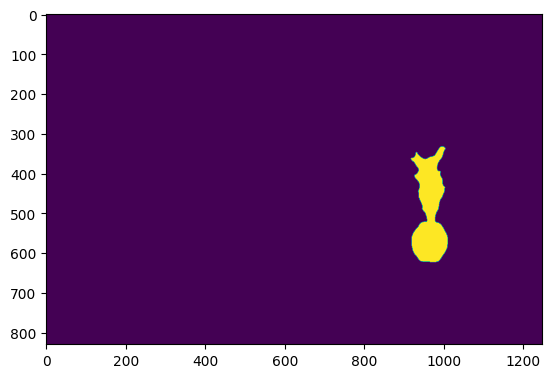

In [21]:
plt.imshow(masks[best_mask_index])
plt.show()

In [23]:
mask_image = Image.fromarray((best_mask * 255).astype(np.uint8))

# Save the image
mask_image.save("image_masked.png")

print("Best mask saved as image_masked.png")


Best mask saved as image_masked.png


## Remove vase from original image

In [24]:
import numpy as np
from PIL import Image

# Function to apply mask to image
def apply_mask_to_image(image_path, mask_path, output_path):
    """
    Apply a mask to an image and superimpose the result.

    Args:
        image_path (str): Path to the original image.
        mask_path (str): Path to the mask image (black and white mask).
        output_path (str): Path to save the resulting masked image.
    """
    # Load the original image
    original_image = Image.open(image_path).convert("RGBA")

    # Load the mask image (mask should be grayscale: white for the object, black for the background)
    mask_image = Image.open(mask_path).convert("L")

    # Resize the mask to match the original image dimensions
    mask_image = mask_image.resize(original_image.size)

    # Convert the images to NumPy arrays
    image_array = np.array(original_image)
    mask_array = np.array(mask_image)

    # Stack the mask to match the RGB channels (mask applies equally to R, G, and B channels)
    masked_image_rgb = np.stack([mask_array] * 3, axis=-1)

    # Superimpose the mask on the image (black where mask is white, original image where mask is black)
    result_image = np.where(masked_image_rgb == 255, 0, image_array[:, :, :3])  # Keep RGB channels

    # Convert the result back to an image
    result_image_p = Image.fromarray(result_image.astype(np.uint8))

    # Save the result
    result_image_p.save(output_path)
    print(f"Masked image saved to {output_path}")

# Example usage
image_path = "/content/room_with_furniture.png"  # Change to your image path
mask_path = "/content/image_masked.png"  # Change to your mask path
output_path = "result_image_after_mask_superimposition.png"  # Output path for the masked image

apply_mask_to_image(image_path, mask_path, output_path)


Masked image saved to result_image_after_mask_superimposition.png


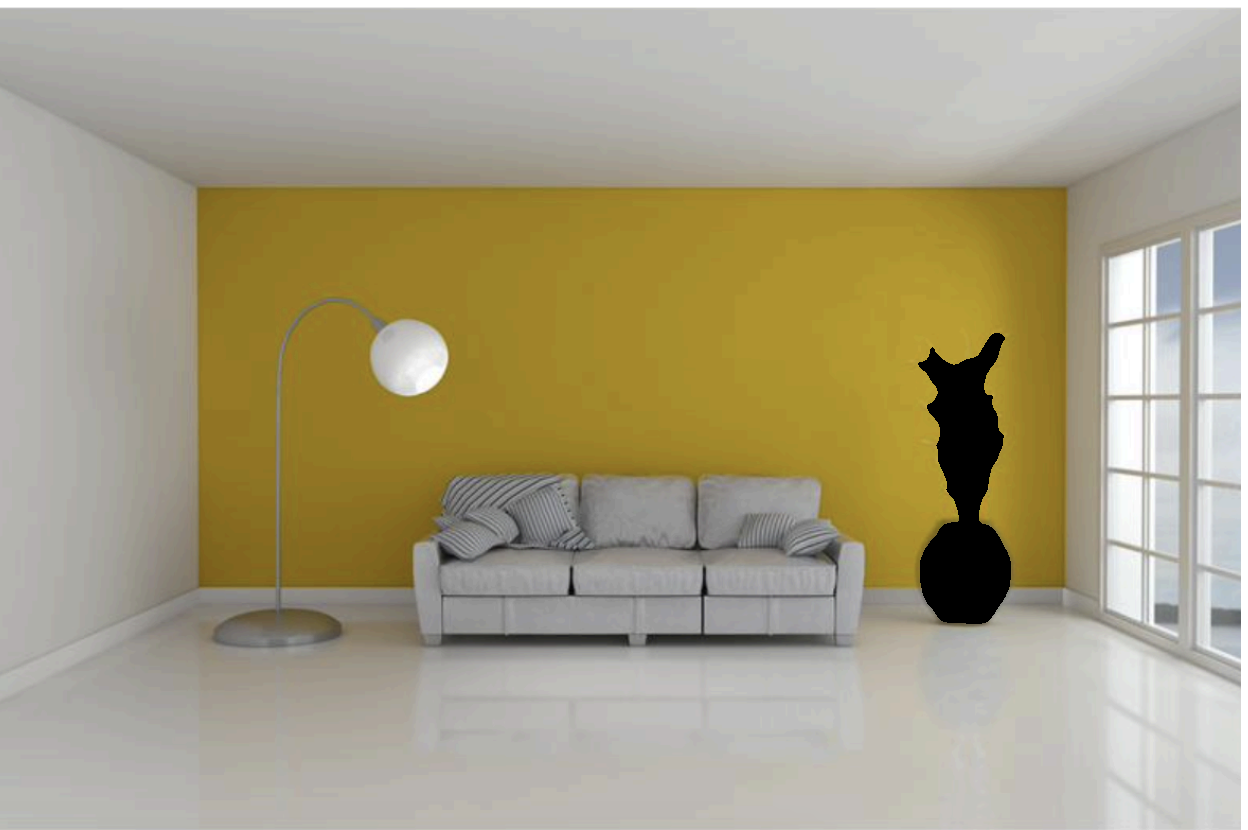

In [26]:
superimposed_image = Image.open("/content/result_image_after_mask_superimposition.png")
superimposed_image

#Inpainting

source - claude

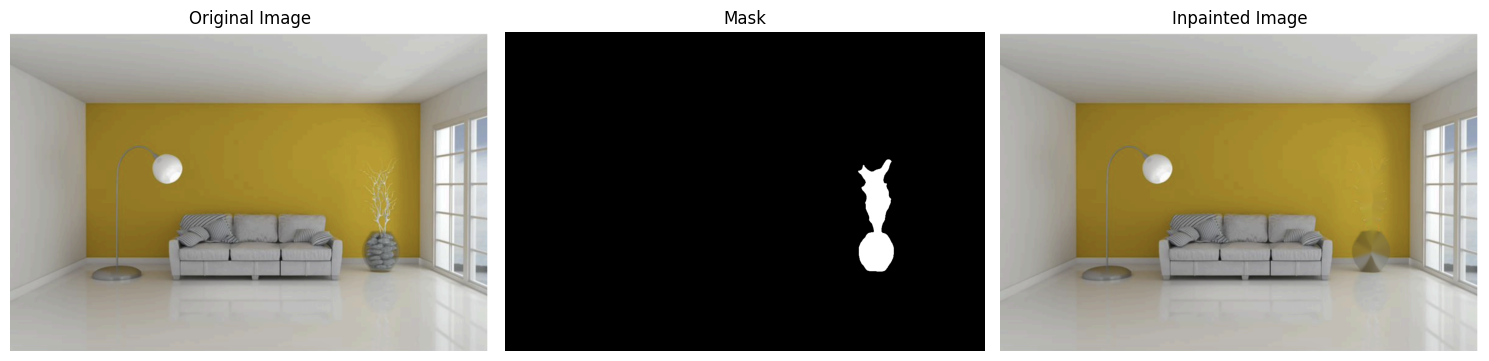

Inpainted image saved to inpainted_image.png


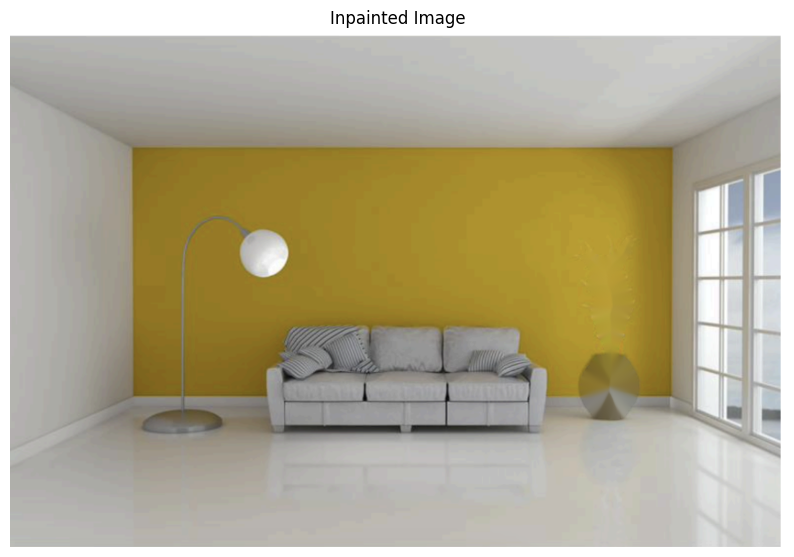

In [31]:
inpaint_image(image_path, "/content/image_masked.png")

# Load the inpainted image
inpainted_image = cv2.imread('inpainted_image.png')
inpainted_image = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

# Display the inpainted image
plt.figure(figsize=(10, 10))
plt.title("Inpainted Image")
plt.imshow(inpainted_image)
plt.axis("off")
plt.show()